# Fit Basic One Current Model

In [1]:
from brian2 import *
from brian2modelfitting import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [4]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [5]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [6]:
np.shape(Vout)

(20, 22399)

In [7]:
Vout

array([[-0.02855869, -0.02865738, -0.02878897, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02873963, -0.02862449, -0.02873963, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02829552, -0.02832841, -0.02803234, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02564731, -0.02572955, -0.0257131 , ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02439722, -0.02418339, -0.02428208, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.02135425, -0.02138714, -0.02122266, ..., -0.02329517,
        -0.02314713, -0.02311424]])

In [8]:
Vout

array([[-0.02855869, -0.02865738, -0.02878897, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02873963, -0.02862449, -0.02873963, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02829552, -0.02832841, -0.02803234, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02564731, -0.02572955, -0.0257131 , ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02439722, -0.02418339, -0.02428208, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.02135425, -0.02138714, -0.02122266, ..., -0.02329517,
        -0.02314713, -0.02311424]])

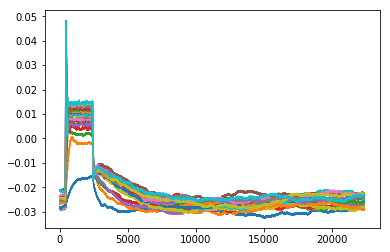

In [9]:
plot(Vout.transpose());

#### Get positive injection current

In [10]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

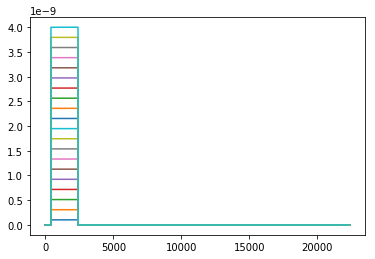

In [11]:
plot(Ic.transpose());

#### Get white noise injection

In [12]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

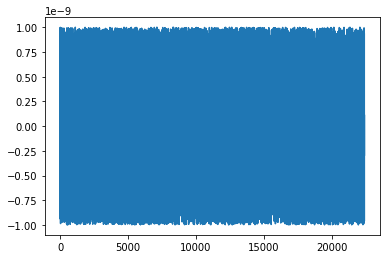

In [13]:
plot(Inoise);

#### Get V from white noise

In [14]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

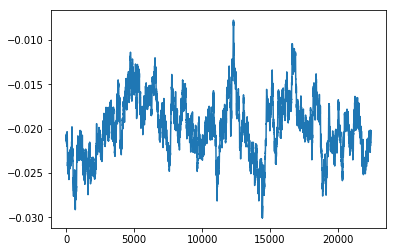

In [15]:
plot(Vnoise);

### Concatinate the data

In [16]:
output = np.concatenate((Vout[:,:10000], [Vnoise[:10000]]))
np.shape(output)

(21, 10000)

In [17]:
input_cur = np.concatenate((Ic[:, :10000], [Inoise[:10000]]))
np.shape(input_cur)

(21, 10000)

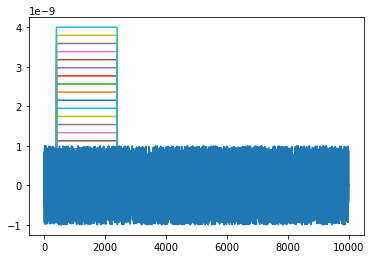

In [18]:
plot(input_cur.transpose());

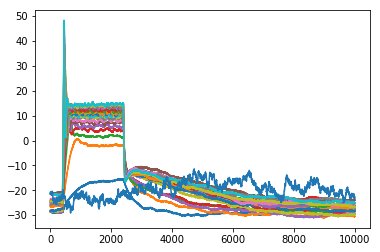

In [19]:
plot((output/1e-3).transpose());

## Define a model

In [20]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
# C = 300*pF,
# EL = -30*mV,
# gL = 1/50*1/Mohm
)

In [21]:
n_opt = NevergradOptimizer()
metric = MSEMetric()

## Fitting

In [22]:
fitter = TraceFitter(model=model, input_var='I', output_var='v',
                     input=input_cur * amp, output=output * volt, dt=dt,
                     n_samples=60,
                     param_init={'v': -30*mV},
                     method='exponential_euler',)

In [23]:
res, error = fitter.fit(n_rounds=50,
                        optimizer=n_opt, metric=metric,
                        callback='text',
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],                        
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],
                        g_k=[1e-1*uS, 1e2*uS],
                        taun=[1*ms, 40*ms],
                       )

Round 0: fit (0.006723536796077323, 0.010456673540511016, 0.009477055330332773, -0.01971029046529326, 2.168499322404641e-10, 1.3580765328482134e-08, 7.841449538263186e-05, -0.05785224824454136) with error: 0.5386641670957658
Round 1: fit (0.006723536796077323, 0.010456673540511016, 0.009477055330332773, -0.01971029046529326, 2.168499322404641e-10, 1.3580765328482134e-08, 7.841449538263186e-05, -0.05785224824454136) with error: 0.5386641670957658
Round 2: fit (0.0071703345538405286, 0.014884705112421999, 0.004075087358705182, -0.024772745127419313, 3.008864079356396e-10, 1.6793806746921017e-08, 8.082724467470269e-05, -0.016211846373785997) with error: 0.2888673051532402
Round 3: fit (0.006303464428682248, 0.015044234531920156, 0.0035287243763891495, -0.022007354505836726, 2.388360865494301e-10, 1.6193814377205026e-08, 8.917079295064391e-05, -0.029017647392959506) with error: 0.2610354194890222
Round 4: fit (0.006202414678521821, 0.01671089896733972, 0.005270986145740021, -0.023130244098

In [24]:
## Show results
all_output = fitter.results(format='dataframe')
# print(all_output)

In [25]:
## Visualization of the results
start_scope()
fits = fitter.generate_traces(params=None, param_init={'v': -30*mV})

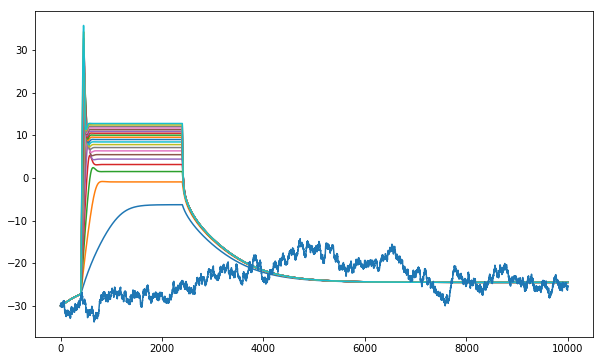

In [26]:
plt.figure(figsize=(10,6))
plot((fits/mV).transpose());

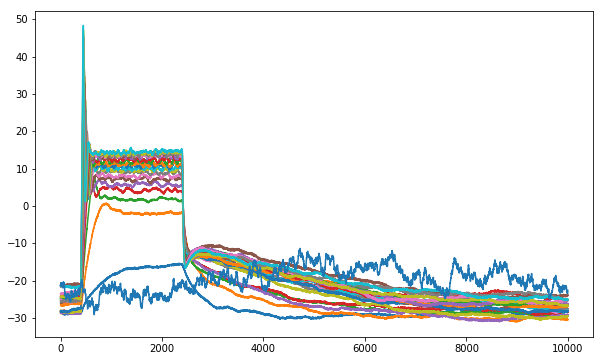

In [27]:
plt.figure(figsize=(10,6))
plot((output/1e-3).transpose());